In [406]:
import os
import sys
import pandas as pd
import googletrans
from googletrans import Translator
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns

In [407]:
# Constants
ROOT_PATH = os.path.abspath(os.getcwd())
SEED = 170

# bycode 2018 excel
BYCODE = os.path.join(ROOT_PATH,"bycode2018.xlsx")

# index 2018 excel
INDEX = os.path.join(ROOT_PATH,"index 2018.xlsx")
NATURAL = "Natural Area"
DISTRICT = "District"
RELIGION = "Religion"
SETTLEMENT_TYPE = "Settlement Type"


# elections data
SETTELMENT21 = os.path.join(ROOT_PATH,"21settelments.xlsx")
SETTELMENT22 = os.path.join(ROOT_PATH,"22settelments.xlsx")
SETTELMENT23 = os.path.join(ROOT_PATH,"23settelments.xlsx")


In [408]:
def total_voters(df):
    "ploting a barchar from dataframe"
    dict={}
    for c in df.columns[7:]:
        dict[c]=(df[c].sum()/df['valid votes'].sum())*100
    plt.figure(figsize=(20,10))
    plt.bar(range(len(dict)), list(dict.values()), align='center')
    plt.ylabel('Voter turnout')
    plt.xlabel('Parties')
    plt.xticks(range(len(dict)), list(dict.keys()))
    plt.show()

### dataframe manipulation functions

In [409]:
def inner_join(df_1,df_2,column_name):
    """makes inner-join between dataframes on the specified column"""
    return pd.merge(left=df_1, right=df_2, left_on= column_name, right_on=column_name)

def remove_small_parties(df,threshold):
    """remove parties that didnt pass the threshold"""
    
    for column in df.columns[7:]:
            if df[column].sum() < threshold:
                   df = df.drop(column,axis=1)
    return df

def unite_parties (df):
    """ unites small parties to factions
    
    We think those factions represent the israeli society
    """
    
    d={'United Torah Judaism':'Haredi','Shas':'Haredi', 'Avoda':'Left','Meretz':'Left',
       'Consolidation of right-wing parties':'Right','Kolano':'Right','Israel is our Home':'Right','New Right':'Right',
        'UAL-Balad':'Arab','Hadash':'Arab' ,'Gesher Avoda':'Left','Joint list':'Arab','right':'Right'
        ,'Avoda-Meretz-Gesher':'Left'}
    
    faction=['Haredi','Right','Arab','Left']
    for f in faction:
        df.insert(len(df.columns),f ,0)
    for c in  df.columns[7:]:
        if c in d:
            s=df[d[c]]+df[c]
            df[d[c]]=s
   
    for c in d.keys():
        if c in df.columns:
              df=df.drop(c,axis=1)
    return df

def normalize_to_voting_ratios(df_original):
    """normalizing the votes according to proportion of votes per party"""
   
    columns = ['Haredi','Right','Arab','Left','Likud','Blue and white']
    df = df_original.copy()
    df = df[columns].astype(float)
    
    
    for i,r in df_original.iterrows():
        for c in columns:
            x = r[c]/r['valid votes']
            df.at[i , c]=x
            
    return df[columns]

def add_most_voted_colm(df):
    """ adds a column of labels for the most voted faction """
    temp = df.copy()
    temp = temp[['Haredi','Right','Arab','Left','Likud','Blue and white']]
    
    for c in temp.columns:
        temp[c] = pd.to_numeric(temp[c])
    
    colm = temp.idxmax(axis=1)
    df["chosen"] = colm
    return df
        

### vector preparation 

In [410]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ 
    Returns the angle in radians between vectors 'v1' and 'v2'
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1, v2_u), -1.0, 1.0))

def prepare_vectors(df):
    """calculates the distance and the angle of each vector from the base_vector"""
    
    df = df.values
    
    matrix = [] 
    vector_base = np.zeros(df.shape[1])
    vector_base.fill(0.1)

    for row in df:
        dist = np.linalg.norm(row)
        angle = angle_between(vector_base,row)
        matrix.append([dist,angle])
    
    
    df = pd.DataFrame(matrix,columns=["dist","angle"])
    return df
    

### Ploting methods

In [411]:
def barchar_group(df,x_var,groupby_var,size,name):
    """creates a barchar that represents aggregation results"""
    
    df_agg = df.loc[:, [x_var, groupby_var]].groupby(groupby_var)
    vals = [df[x_var].values.tolist() for i, df in df_agg]

    # Draw
    plt.figure(figsize=(16,9), dpi= 80)
    colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
    n, bins, patches = plt.hist(vals, df[x_var].unique().__len__(), stacked=False, density=False, color=colors[:len(vals)])

    # Decoration
    plt.legend({group:col for group, col in zip(np.unique(df[groupby_var]).tolist(), colors[:len(vals)])})
    plt.title(name, fontsize=22)
    plt.xlabel(x_var)
    plt.ylabel("Frequency")
    plt.ylim(0, size)
    plt.xticks(ticks=bins, labels=np.unique(df[x_var]).tolist(), rotation=90, horizontalalignment='left')
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

In [412]:
le = LabelEncoder()

bycode = pd.read_excel(BYCODE,dtype=object)
index = pd.read_excel(INDEX,sheet_name=SETTLEMENT_TYPE)
df_21 = pd.read_excel(SETTELMENT21,dtype=object)

df_21 = remove_small_parties(df_21,135720)
df_21 = unite_parties(df_21)
df_21 = add_most_voted_colm(df_21)
df_21 = inner_join(df_21,bycode,"code")
df_21 = inner_join(df_21,index,"Settlement type code")
df_21 = df_21.fillna(0)

df_base = df_21[["Likud","Blue and white",'Haredi','Right','Arab','Left',"chosen","Settlement type","valid votes"]]

In [413]:
df = df_base.copy()
df['Settlement type'] = le.fit_transform(df['Settlement type'])
df["chosen"] = le.fit_transform(df['chosen'])

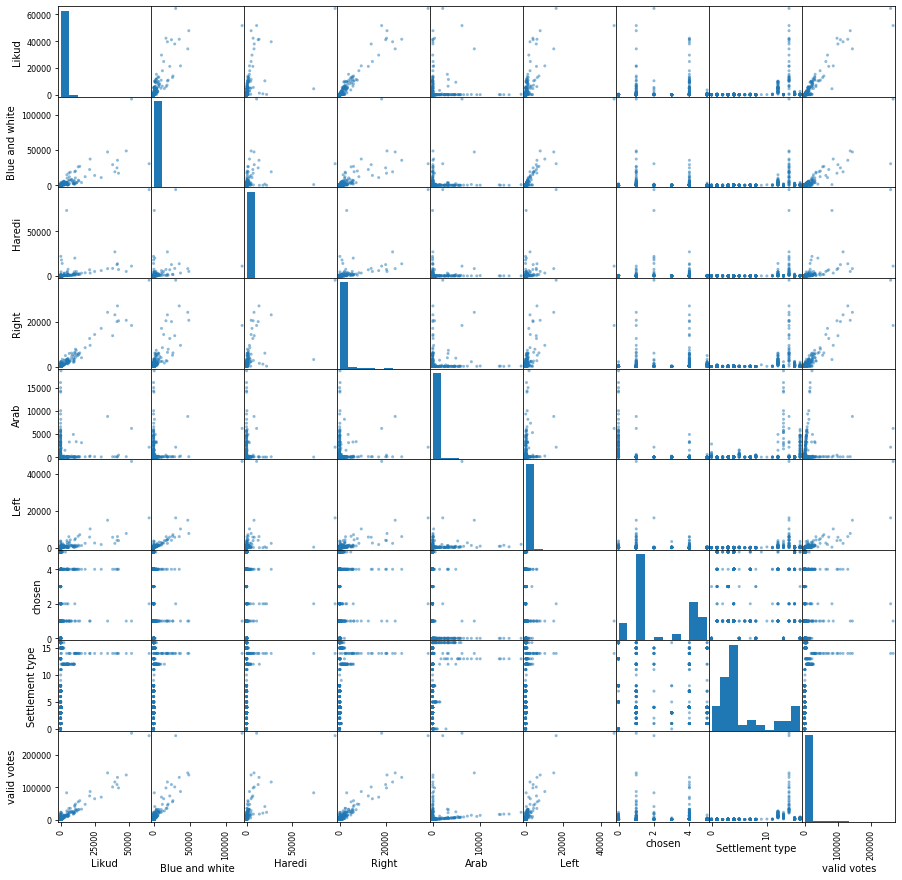

In [414]:
pd.plotting.scatter_matrix(df,  figsize=(15, 15))
plt.show()

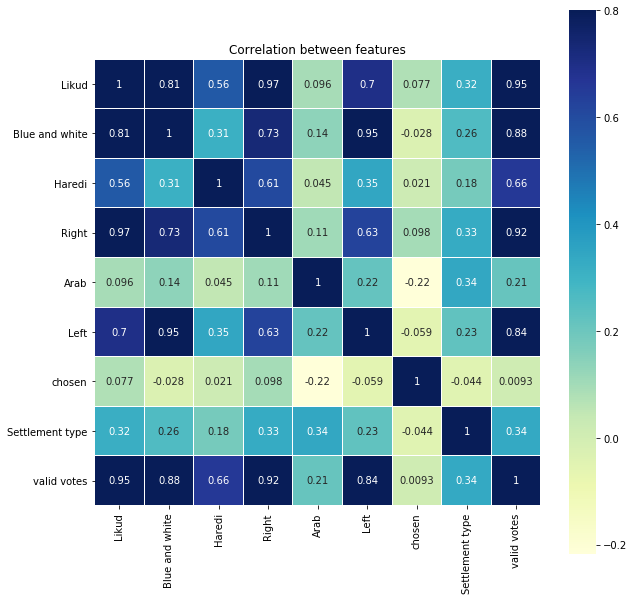

In [415]:
corr=df.corr()
plt.figure(figsize=(10, 10))

sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

In [416]:
df_normalized = normalize_to_voting_ratios(df_base)
vectors = prepare_vectors(df_normalized)

Text(0.5, 1.0, 'Incorrect Number of Blobs')

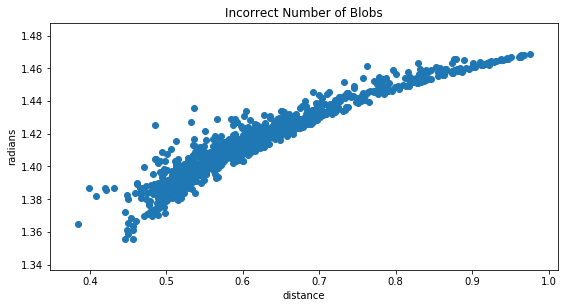

In [417]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.scatter(vectors["dist"], vectors["angle"])
plt.xlabel('distance')
plt.ylabel('radians')
plt.title("Incorrect Number of Blobs")

In [418]:
Sum_of_squared_distances = []
K = range(1,6)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(vectors)
    Sum_of_squared_distances.append(km.inertia_)

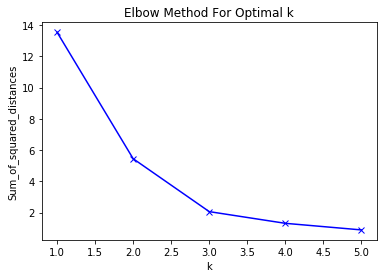

In [419]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [420]:
km = KMeans(n_clusters=3)
km.fit(vectors)
y = km.predict(vectors)

df_base['Cluster Class'] = pd.Series(y, index=df_base.index)
vectors['Cluster Class'] = pd.Series(y, index=vectors.index)

C:\Users\gabi9\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Text(0.5, 1.0, 'Incorrect Number of Blobs')

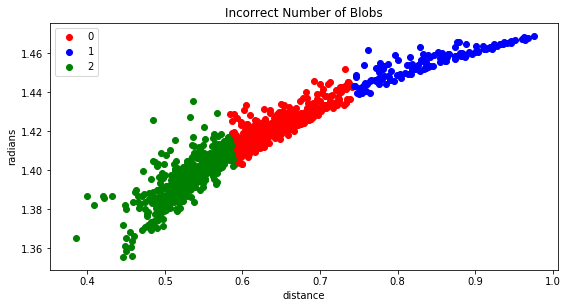

In [421]:
df = vectors.groupby('Cluster Class')

plt.figure(figsize=(20,10))
plt.subplot(221)

colors = itertools.cycle(["r", "b", "g"])

for name,cluster in df:
    plt.scatter(cluster["dist"], cluster["angle"],label = name,color =next(colors))

plt.xlabel('distance')
plt.ylabel('radians')
plt.legend()
plt.title("Incorrect Number of Blobs")

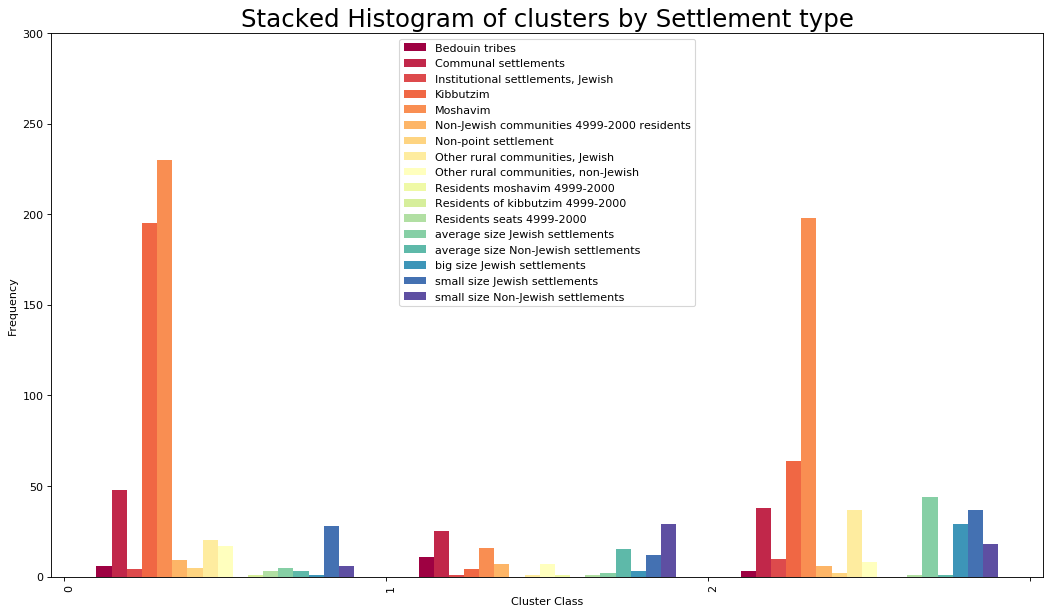

In [422]:
barchar_group(df_base,"Cluster Class","Settlement type",300, "Stacked Histogram of clusters by Settlement type")

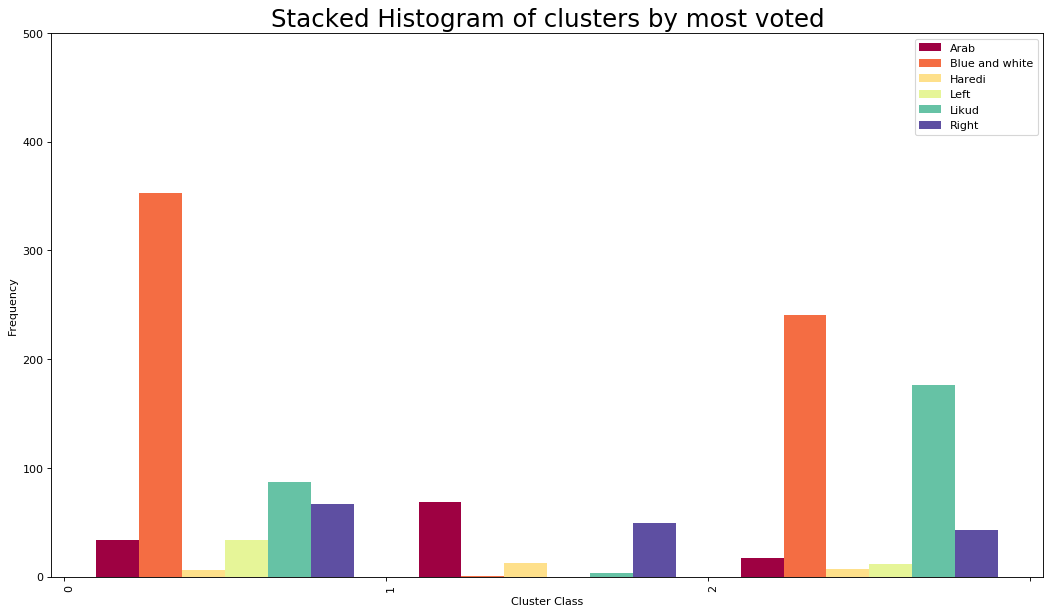

In [423]:
barchar_group(df_base,"Cluster Class","chosen",500,"Stacked Histogram of clusters by most voted")

In [424]:
from sklearn import mixture

lowest_bic = np.infty
bic = []
n_components_range = range(1, 4)
cv_types = ['spherical', 'tied', 'diag', 'full']

for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(vectors)
        bic_score = gmm.bic(vectors)
        if bic_score < lowest_bic:
            lowest_bic = bic_score
            best_gmm = gmm

y = gmm.predict(vectors)
df_base['Cluster Class'] = pd.Series(y, index=df_base.index)
vectors['Cluster Class'] = pd.Series(y, index=vectors.index)

C:\Users\gabi9\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'Incorrect Number of Blobs')

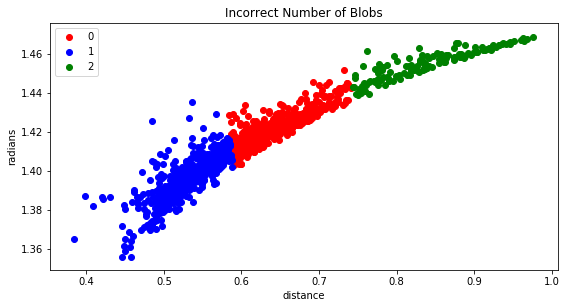

In [425]:
df = vectors.groupby('Cluster Class')

plt.figure(figsize=(20,10))
plt.subplot(221)

colors = itertools.cycle(["r", "b", "g"])


for name,cluster in df:
    plt.scatter(cluster["dist"], cluster["angle"],label = name,color =next(colors))

plt.xlabel('distance')
plt.ylabel('radians')
plt.legend()
plt.title("Incorrect Number of Blobs")

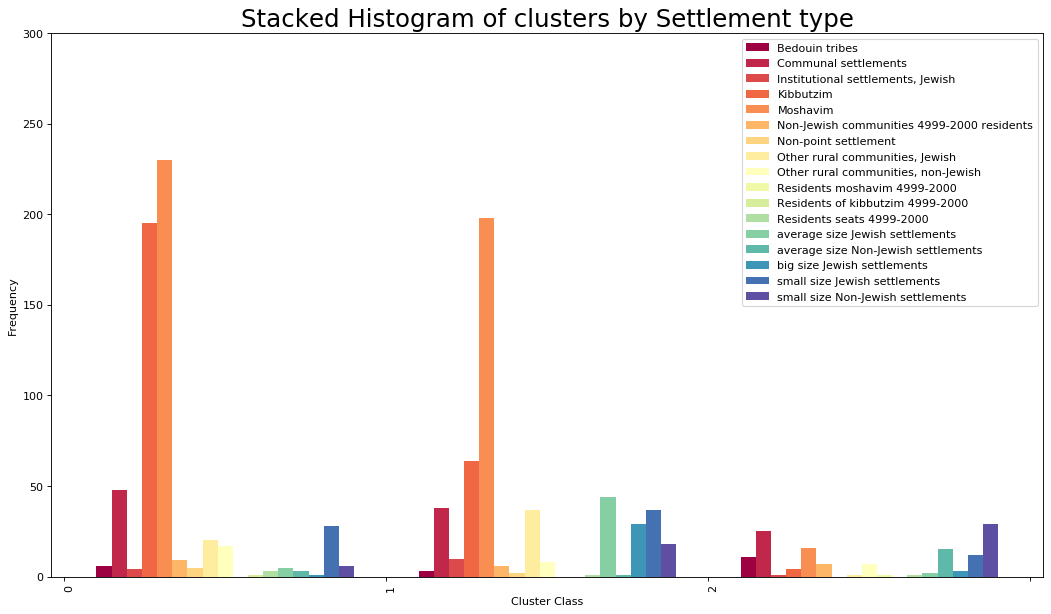

In [426]:
barchar_group(df_base,"Cluster Class","Settlement type",300,"Stacked Histogram of clusters by Settlement type")

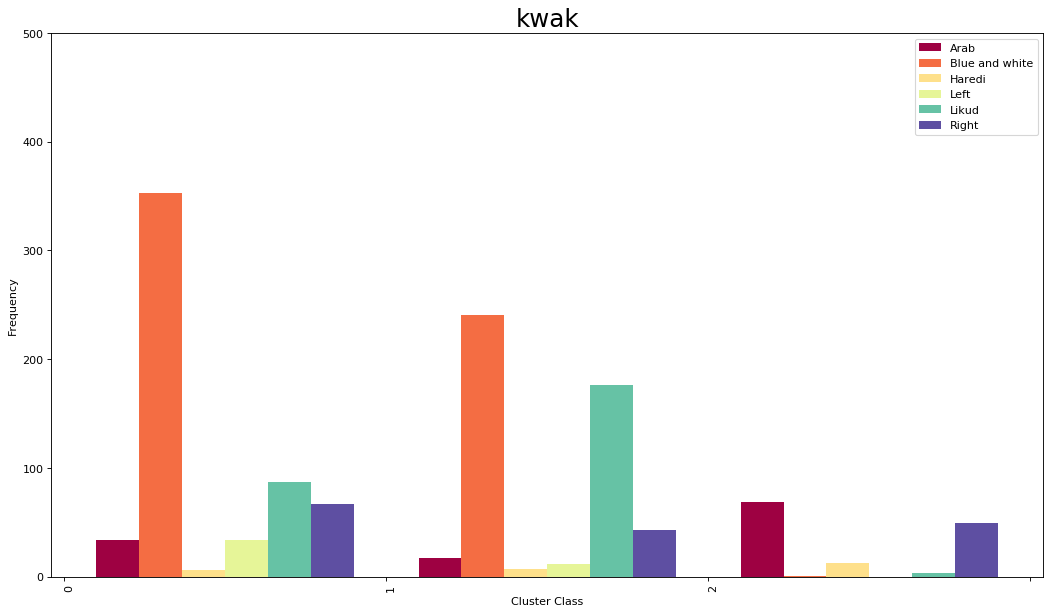

In [427]:
barchar_group(df_base,"Cluster Class","chosen",500,"kwak")

In [428]:
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import  metrics
param_grid = {
    'n_estimators': [100, 150, 200, 250],  # The number of trees in the forest.
    'max_depth': [None, 50, 60, 70],  # The maximum depth of the tree.
    'max_features': ['sqrt', None,'log2'],  # he number of features to consider when looking for the best split
    'min_samples_split': [2, 5, 10],  # The minimum number of samples required to split an internal node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees.
}

df21 = pd.read_excel(SETTELMENT21)
df21 = remove_small_parties(df21,135720)
df21 = unite_parties(df21)
df21=df21[["Voters","Disqualified","Holders of voting rights","Likud",
           "Blue and white","Haredi","Right","Arab","Left","valid votes"]]

df22 = pd.read_excel(SETTELMENT22)
df22 = remove_small_parties(df22,135720)
df22 = unite_parties(df22)
df22=df22[["Voters","Disqualified","Holders of voting rights","Likud",
           "Blue and white","Haredi","Right","Arab","Left","valid votes"]]


df23 = pd.read_excel(SETTELMENT23)
df23 = remove_small_parties(df23,135720)
df23 = unite_parties(df23)
a=["HAIFA","ELAT","AYYELET HASHAHAR","SAKHNIN","QAZRIN"]
df23 = df23[df23.name.isin(a)]
locations=df23[['name']].values.tolist()
df23=df23[["Voters","Disqualified","Holders of voting rights","Likud",
           "Blue and white","Haredi","Right","Arab","Left","valid votes"]]

df=pd.concat([df21, df22])

x_train=df.iloc[:,:-1]
y_train=df.iloc[:,-1]
x_test=df23.iloc[:,:-1]
y_test=df23.iloc[:,-1]

estimator = RandomForestRegressor(random_state=SEED)

rs = GridSearchCV(estimator, param_grid, n_jobs=-1,
                        scoring='neg_root_mean_squared_error', cv=5,
                        verbose=1)

rs.fit(x_train,y_train)
predict_y = rs.predict(x_test)
actual=df23.iloc[:,-1].values

for  i in range(len(predict_y)):
        print("predection for "+str(locations[i])+ " is "+str(predict_y[i])+" while the true value is "+
                                    str(actual[i]))
    
metrics.mean_absolute_error(predict_y,actual)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  7.5min finished


predection for ['AYYELET HASHAHAR'] is 585.42 while the true value is 585
predection for ['ELAT'] is 22705.08 while the true value is 22636
predection for ['HAIFA'] is 141826.26 while the true value is 144625
predection for ['SAKHNIN'] is 17459.87 while the true value is 17085
predection for ['QAZRIN'] is 3484.21 while the true value is 3498


651.3799999999983

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import  metrics



le = LabelEncoder()

param_grid = {'n_estimators':[50,100,150,200,250,300], #Number of weak learners to train iteratively., 
                  'learning_rate':[0.001, 0.01, 0.1, 1], #It contributes to the weights of weak learners. It uses 1 as a default value.,
                   'loss' : ['linear', 'square', 'exponential']}

bycode = pd.read_excel(BYCODE)
sett_type = pd.read_excel(INDEX,sheet_name=SETTLEMENT_TYPE)
natru = pd.read_excel(INDEX,sheet_name=NATURAL)

df21 = pd.read_excel(SETTELMENT21)
df21 = remove_small_parties(df21,135720)
df21 = unite_parties(df21)
df21 = inner_join(df21,bycode,"code")
df21 = inner_join(df21,sett_type,"Settlement type code")
df21.fillna(0,inplace = True)

df22 = pd.read_excel(SETTELMENT22)
df22 = remove_small_parties(df22,135720)
df22 = unite_parties(df22)
df22 = inner_join(df22,bycode,"code")
df22 = inner_join(df22,sett_type,"Settlement type code")
df22.fillna(0,inplace = True)

df23 = pd.read_excel(SETTELMENT23)
df23 = remove_small_parties(df23,135720)
df23 = unite_parties(df23)
df23 = inner_join(df23,bycode,"code")
df23 = inner_join(df23,sett_type,"Settlement type code")
df23.fillna(0,inplace = True)

a=["HAIFA","ELAT","AYYELET HASHAHAR","SAKHNIN","QAZRIN"]
df23 = df23[df23.name_x.isin(a)]
locations=df23[['name_x']].values.tolist()

df=pd.concat([df21, df22])
df['Settlement type'] = le.fit_transform(df['Settlement type'])
df23['Settlement type'] = le.fit_transform(df23['Settlement type'])


#Likud
colms= ["Likud","Settlement type","Planning Commission","Organizational affiliation",
        "Religion code","Status Montzifali","Natural area code","Subdistrict code","District code"]
df_temp = df[colms].copy()
test = df23[colms].copy()

y_train = df_temp["Likud"]
x_train = df_temp.drop("Likud",axis = 1)
y_test = test["Likud"]
x_test = test.drop("Likud",axis=1)

rs = GridSearchCV(AdaBoostRegressor(),param_grid,cv=5,scoring = 'neg_mean_squared_error')
rs.fit(x_train, y_train)
adb=rs.best_estimator_
adb = AdaBoostRegressor(adb)
adb.fit(x_train, y_train)
print(metrics.mean_squared_error(y_test,adb.predict(x_test)))


#Blue and white
colms= ["Blue and white","Settlement type","Planning Commission","Organizational affiliation",
        "Religion code","Status Montzifali","Natural area code","Subdistrict code","District code"]
df_temp = df[colms].copy()
test = df23[colms].copy()

y_train = df_temp["Blue and white"]
x_train = df_temp.drop("Blue and white",axis = 1)
y_test = test["Blue and white"]
x_test = test.drop("Blue and white",axis=1)

rs =  GridSearchCV(AdaBoostRegressor(),param_grid,cv=5,scoring = 'neg_mean_squared_error')
rs.fit(x_train, y_train)
adb=rs.best_estimator_
adb = AdaBoostRegressor(adb)
adb.fit(x_train, y_train)
print(metrics.mean_squared_error(y_test,adb.predict(x_test)))


#Arab
colms= ["Arab","Settlement type","Planning Commission","Organizational affiliation",
        "Religion code","Status Montzifali","Natural area code","Subdistrict code","District code"]
df_temp = df[colms].copy()
test = df23[colms].copy()

y_train = df_temp["Arab"]
x_train = df_temp.drop("Arab",axis = 1)
y_test = test["Arab"]
x_test = test.drop("Arab",axis=1)

rs =  GridSearchCV(AdaBoostRegressor(),param_grid,cv=5,scoring = 'neg_mean_squared_error')
rs.fit(x_train, y_train)
adb=rs.best_estimator_
adb = AdaBoostRegressor(adb)
adb.fit(x_train, y_train)
print(metrics.mean_squared_error(y_test,adb.predict(x_test)))





In [430]:
from sklearn.ensemble import AdaBoostRegressor


def getdataRegress(num , RF ,n=None):
    
        df = get_data(SETTELMENT,num)
        df = remove_small_parties(df,135720)
        df = unite_parties(df)
        if RF:
            return df[["committee code","Voters","Disqualified","Holders of voting rights","Likud",
                   "Blue and white","Haredi","Right","Arab","Left","valid votes"]]
        if n == 1:
            return df[["committee code","Voters","Disqualified","Holders of voting rights","Likud",
                   "Haredi","Right","Arab","Left","valid votes","Blue and white"]]
        elif n == 2:
            return df[["committee code","Voters","Disqualified","Holders of voting rights",
                   "Blue and white","Haredi","Right","Arab","Left","valid votes","Likud"]]
        else:
            return df[["committee code","Voters","Disqualified","Holders of voting rights","Likud",
                   "Blue and white","Haredi","Right","Left","valid votes","Arab"]

df21=getdataRegress(21,False,1)
df22=getdataRegress(22,False,1)
df23 = get_data(SETTELMENT,23)
df23 = remove_small_parties(df23,135720)
df23 = unite_parties(df23)
a=["JERUSALEM","BENE BERAQ","SAKHNIN","KARMI'EL","DALIYAT AL-KARMEL"]
df23 = df23[df23.name.isin(a)]
locations=df23[['name']].values
df23=df23[["committee code","Voters","Disqualified","Holders of voting rights","Likud",
           "Haredi","Right","Arab","Left","valid votes","Blue and white"]]
print(df22)
df=pd.concat([df21, df22])
x_train=df.iloc[:,:-1]
y_train=df.iloc[:,-1]
x_test=df23.iloc[:,:-1]
y_test=df23.iloc[:,-1]
param_grid = {'n_estimators':[50,100,150,200,250], #Number of weak learners to train iteratively., 
                  'learning_rate':[0.001, 0.01, 0.1, 1], #It contributes to the weights of weak learners. It uses 1 as a default value.,
                   'loss' : ['linear', 'square', 'exponential']}

rs = RandomizedSearchCV(AdaBoostRegressor(),param_grid,cv=5,n_iter = 10,n_jobs=-1)
rs.fit(x_train, y_train)
ADB_best=rs.best_estimator_
adb = AdaBoostRegressor(ADB_best)
adb.fit(x_train, y_train)
predict_y = adb.predict(x_test)
actual=df23.iloc[:,-1].values
i=0
while i< len(predict_y):
        print("predection for "+str(locations[i])+ " is "+str(predict_y[i])+" while the true value is "+
                                    str(actual[i]))
        i=i+1



df21=getdataRegress(21,False,2)
df22=getdataRegress(22,False,2)
df23 = get_data(SETTELMENT,23)
df23 = remove_small_parties(df23,135720)
df23 = unite_parties(df23)
df23 = df23[df23.name.isin(a)]
locations=df23[['name']].values
df23=df23[["committee code","Voters","Disqualified","Holders of voting rights",
                   "Blue and white","Haredi","Right","Arab","Left","valid votes","Likud"]]
print(df22)
df=pd.concat([df21, df22])
x_train=df.iloc[:,:-1]
y_train=df.iloc[:,-1]
x_test=df23.iloc[:,:-1]
y_test=df23.iloc[:,-1]
param_grid = {'n_estimators':[50,100,150,200,250], #Number of weak learners to train iteratively., 
                  'learning_rate':[0.001, 0.01, 0.1, 1], #It contributes to the weights of weak learners. It uses 1 as a default value.,
                   'loss' : ['linear', 'square', 'exponential']}

rs = RandomizedSearchCV(AdaBoostRegressor(),param_grid,cv=5,n_iter = 10,n_jobs=-1)
rs.fit(x_train, y_train)
ADB_best=rs.best_estimator_
adb = AdaBoostRegressor(ADB_best)
adb.fit(x_train, y_train)
predict_y = adb.predict(x_test)
actual=df23.iloc[:,-1].values
i=0
while i< len(predict_y):
        print("predection for "+str(locations[i])+ " is "+str(predict_y[i])+" while the true value is "+
                                    str(actual[i]))
        i=i+1







SyntaxError: invalid syntax (<ipython-input-430-96089dcb878b>, line 22)

In [435]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import itertools

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 150, 200, 250],#The number of trees in the forest.
    'max_depth': [None, 50, 60, 70] ,#The maximum depth of the tree.
    'max_features': ['sqrt', None],#he number of features to consider when looking for the best split
    'min_samples_split': [2, 5, 10],#The minimum number of samples required to split an internal node
    'bootstrap': [True, False]#Whether bootstrap samples are used when building trees.
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = SEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'accuracy', cv = 5, 
                        n_iter = 1, verbose = 1, random_state=SEED)




df21 = pd.read_excel(SETTELMENT21)
df22 = pd.read_excel(SETTELMENT22)
df23 = pd.read_excel(SETTELMENT23)

df21 = pd.read_excel(SETTELMENT21)
df21 = remove_small_parties(df21,135720)
df21 = unite_parties(df21)

df22 = pd.read_excel(SETTELMENT22)
df22 = remove_small_parties(df22,135720)
df22 = unite_parties(df22)

df23 = pd.read_excel(SETTELMENT23)
df23 = remove_small_parties(df23,135720)
df23 = unite_parties(df23)

bycode = pd.read_excel(BYCODE)
settlment_type = pd.read_excel(INDEX,sheet_name=SETTLEMENT_TYPE)

bycode.fillna(0,inplace = True)

def label(row,total):
    prop  = row["Disqualified"] / total
    
    val = 0
    
    if prop > 0.01:
        val = 1
    
    return val

total = df21["Disqualified"].sum()
df21['class'] = df21.apply(lambda row : label(row, total), axis = 1) 
df = inner_join(df21,bycode,"code")
df = inner_join(df,settlment_type,"Settlement type code")
df['Settlement type'] = le.fit_transform(df['Settlement type'])
df21 = df.drop(["code","name_y","name_x","code","Settlement type code","Holders of voting rights", "Voters","Disqualified","valid votes","Likud","Blue and white","Haredi","Right","Arab","Left"],axis = 1)




total = df22["Disqualified"].sum()
df22['class'] = df22.apply(lambda row : label(row, total), axis = 1)
df = inner_join(df22,bycode,"code")
df = inner_join(df,settlment_type,"Settlement type code")
df['Settlement type'] = le.fit_transform(df['Settlement type'])
df22 = df.drop(["code","name_y","name_x","code","Settlement type code","Holders of voting rights", "Voters","Disqualified","valid votes","Likud","Blue and white","Haredi","Right","Arab","Left"],axis = 1)

df=pd.concat([df21, df22])
df= df.fillna(0)
y = df["class"]
x = df.drop("class",axis = 1)

rs.fit(x,y)

total = df23["Disqualified"].sum()
df23['class'] = df23.apply(lambda row : label(row, total), axis = 1) 
df = inner_join(df23,bycode,"code")
df = inner_join(df,settlment_type,"Settlement type code")
df['Settlement type'] = le.fit_transform(df['Settlement type'])
df.drop(["name_y","name_x","code","Settlement type code","Holders of voting rights", "Voters","Disqualified","valid votes","Likud","Blue and white","Haredi","Right","Arab","Left"],axis = 1, inplace = True)
df= df.fillna(0)

test_y = df["class"]
test_x = df.drop("class",axis = 1)

y_predict = rs.predict(test_x)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


Confusion matrix, without normalization
[[1191    0]
 [   0   21]]


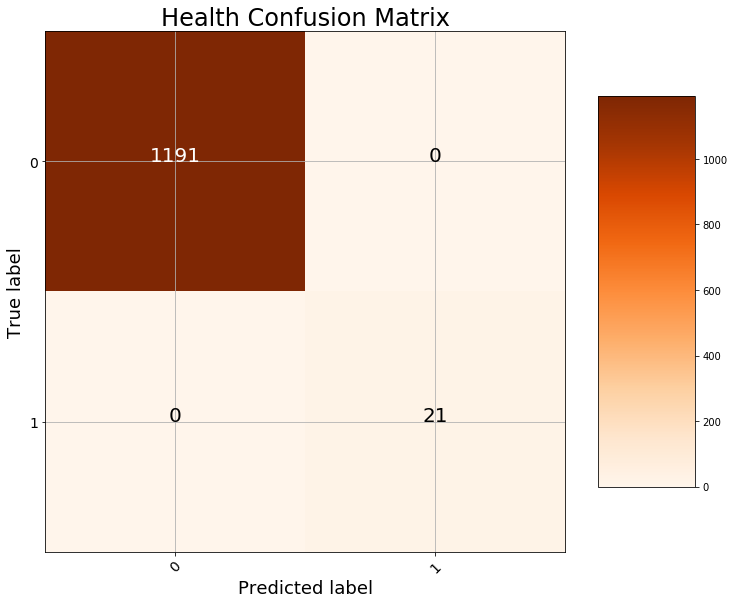

In [432]:
cm = confusion_matrix(test_y, y_predict)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'Health Confusion Matrix')